In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

In [2]:
BASE_DIR = 'C:/Users/d/Desktop/Programme du projet sur CNN pauvreté/'
COUNTRIES_DIR = os.path.join(BASE_DIR, 'Data', 'countries')
PROCESSED_DIR = os.path.join(BASE_DIR, 'Data', 'processed')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
CNN_TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, 'Data', 'cnn_images')
CNN_SAVE_DIR = os.path.join(BASE_DIR, 'models')
CNN_DIR = os.path.join(BASE_DIR, 'models', 'trained_model.pt')


In [8]:
import os
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, 'CIV_2018'), exist_ok=True)

# Extraction de caractéristiques


In [9]:
df_images = pd.read_csv(os.path.join(PROCESSED_DIR, 'image_download_actual.csv'))

In [10]:
df_images

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,pcexp,nightlights,nightlights_bin,is_train
0,5.340532027868917_-4.025852780317594_5.3405411...,5.340532,-4.025853,5.340541,-4.026030,1020831.75,175.0,1,False
1,5.340745282769441_-4.025807235212275_5.3404997...,5.340745,-4.025807,5.340500,-4.026202,1683393.00,175.0,1,False
2,5.340075161680703_-4.025578163599464_5.3397475...,5.340075,-4.025578,5.339747,-4.025963,844232.40,175.0,1,False
3,5.339713165823903_-4.025925594802797_5.3399469...,5.339713,-4.025926,5.339947,-4.026139,1197390.00,175.0,1,False
4,5.337677665186877_-4.026007734859324_5.3380507...,5.337678,-4.026008,5.338051,-4.026206,1239934.10,0.0,0,False
...,...,...,...,...,...,...,...,...,...
3434,6.859985734133001_-6.430992092734161_6.8598360...,6.859986,-6.430992,6.859836,-6.430842,611718.10,186.0,2,True
3435,6.86013545334702_-6.430992092734161_6.85983601...,6.860135,-6.430992,6.859836,-6.430842,611718.10,186.0,2,True
3436,6.86028517256104_-6.430992092734161_6.85983601...,6.860285,-6.430992,6.859836,-6.430842,611718.10,186.0,2,True
3437,6.85938685727692_-6.43084237352014_6.859836014...,6.859387,-6.430842,6.859836,-6.430842,611718.10,186.0,2,True


In [11]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image_name       3439 non-null   object 
 1   image_lat        3439 non-null   float64
 2   image_lon        3439 non-null   float64
 3   cluster_lat      3439 non-null   float64
 4   cluster_lon      3439 non-null   float64
 5   pcexp            3439 non-null   float64
 6   nightlights      3439 non-null   float64
 7   nightlights_bin  3439 non-null   int64  
 8   is_train         3439 non-null   bool   
dtypes: bool(1), float64(6), int64(1), object(1)
memory usage: 218.4+ KB


In [12]:
df_images.head

<bound method NDFrame.head of                                              image_name  image_lat  image_lon  \
0     5.340532027868917_-4.025852780317594_5.3405411...   5.340532  -4.025853   
1     5.340745282769441_-4.025807235212275_5.3404997...   5.340745  -4.025807   
2     5.340075161680703_-4.025578163599464_5.3397475...   5.340075  -4.025578   
3     5.339713165823903_-4.025925594802797_5.3399469...   5.339713  -4.025926   
4     5.337677665186877_-4.026007734859324_5.3380507...   5.337678  -4.026008   
...                                                 ...        ...        ...   
3434  6.859985734133001_-6.430992092734161_6.8598360...   6.859986  -6.430992   
3435  6.86013545334702_-6.430992092734161_6.85983601...   6.860135  -6.430992   
3436  6.86028517256104_-6.430992092734161_6.85983601...   6.860285  -6.430992   
3437  6.85938685727692_-6.43084237352014_6.859836014...   6.859387  -6.430842   
3438  6.859536576490941_-6.43084237352014_6.85983601...   6.859537  -6.430842  

In [13]:
# Importe la bibliothèque PyTorch
import torch
# Détermine si un GPU CUDA est disponible et sélectionne le dispositif (GPU ou CPU) en conséquence
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Affiche le dispositif utilisé (GPU ou CPU) pour informer l'utilisateur
print(f'Using {device} as backend')
# Charge un modèle pré-entraîné depuis le répertoire spécifié par CNN_DIR sur le dispositif sélectionné
model = torch.load(CNN_DIR, map_location=device)


Using cpu as backend


In [14]:
# Accès à la partie classificateur du modèle VGG16, typiquement pour ajuster la couche de sortie afin de correspondre au nombre de classes dans un nouveau jeu de données
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)

In [16]:
'''
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)
'''
# Définition d'un réseau de neurones avec Sequential :
# 1. Première couche linéaire de 25088 caractéristiques d'entrée à 4096 caractéristiques de sortie.
# 2. Fonction d'activation ReLU avec opération sur place pour économiser de la mémoire.
# 3. Couche de Dropout avec une probabilité de 50% pour prévenir le surapprentissage.
# 4. Deuxième couche linéaire de 4096 à 4096 caractéristiques, avec biais.
# 5. Une autre activation ReLU pour la non-linéarité, sur place.
# 6. Une autre couche de Dropout pour la régularisation, probabilité de 50%.
# 7. Dernière couche linéaire réduisant les caractéristiques de 4096 à 3 pour la sortie de classification.


'\nSequential(\n  (0): Linear(in_features=25088, out_features=4096, bias=True)\n  (1): ReLU(inplace=True)\n  (2): Dropout(p=0.5, inplace=False)\n  (3): Linear(in_features=4096, out_features=4096, bias=True)\n  (4): ReLU(inplace=True)\n  (5): Dropout(p=0.5, inplace=False)\n  (6): Linear(in_features=4096, out_features=3, bias=True)\n)\n'

In [17]:
# Suppression des dernières couches du classificateur
#En conservant seulement les premières couches du classificateur,
#on peut transformer le modèle en un extracteur de caractéristiques puissant qui peut être utilisé pour prétraiter les images avant de les passer à un autre classificateur
#ou à une autre partie de notre pipeline de traitement d'images.

model.classifier = model.classifier[:4] 

#nous remplaçons le classificateur actuel du modèle par seulement les quatre premières couches de l'original.
#En Python, [:4] sélectionne les éléments de l'indice 0 à l'indice 3 (le 4ème élément n'est pas inclus),
#donc cela conserve les premières quatre couches du classificateur et enlève tout ce qui suit.


In [19]:
#Mise à jour du classificateur
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

In [24]:
# Définir un ensemble de transformations pour prétraiter les images
transformer = transforms.Compose([
    transforms.ToTensor(),  # Convertir les images en tensors PyTorch
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliser les images
])

# Classe personnalisée pour le chargement rapide des images sans structure de dossier spécifique
class ForwardPassDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transformer):
        self.image_dir = image_dir  # Chemin du dossier contenant les images
        self.image_list = os.listdir(self.image_dir)  # Liste des images
        self.transformer = transformer  # Transformations à appliquer

    def __len__(self):
        return len(self.image_list)  # Nombre d'images dans le dataset

    def __getitem__(self, index):
        image_name = self.image_list[index]  # Nom de l'image à l'index spécifié
        X = self.filename_to_im_tensor(self.image_dir + '/' + image_name)  # Charger et transformer l'image
        return X, -1  # Retourner l'image avec une étiquette fictive
    
    def filename_to_im_tensor(self, file):
        im = plt.imread(file)[:, :, :3]  # Lire l'image et conserver seulement les 3 premiers canaux
        im = self.transformer(im)  # Appliquer les transformations
        return im

model.eval()  # Mettre le modèle en mode évaluation

classes = [0, 1, 2]  # Classes à traiter
feats = np.zeros(((~df_images['is_train']).sum(), 4096))  # Initialiser le tableau pour stocker les caractéristiques
image_order = []  # Liste pour garder l'ordre des images traitées
i = 0
for c in classes:
    # Charger le dataset pour cette classe
    dataset = ForwardPassDataset(os.path.join(CNN_TRAIN_IMAGE_DIR, 'valid', str(c)), transformer)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)
    image_order += dataset.image_list  # Ajouter les noms des images traitées
    for inputs, _ in tqdm(dataloader):
        inputs = inputs.to(device)  # Déplacer les inputs vers le dispositif approprié
        outputs = model(inputs)  # Passer les inputs dans le modèle
        feats[i:i+len(inputs), :] = outputs.cpu().detach().numpy()  # Stocker les caractéristiques extraites
        i += len(inputs)


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
#Chaque ligne du tableau feats contient le vecteur de caractéristiques de 4096 dimensions d'une image.
#Ces caractéristiques sont le résultat du passage de l'image à travers le modèle,
#jusqu'à une couche spécifique du réseau (généralement l'avant-dernière couche dans des architectures comme VGG),
#juste avant la classification finale.
#Les caractéristiques représentent une forme condensée d'informations visuelles extraites de l'image,
#capturant des aspects essentiels nécessaires pour la discrimination entre différentes classes d'images.
#Une fois extraites et stockées dans feats, ces caractéristiques peuvent être utilisées pour diverses tâches d'apprentissage automatique
#et de vision par ordinateur telles que la classification,
#la recherche d'images par similarité, le regroupement d'images, 
#ou même pour des analyses de réduction de dimensionnalité comme PCA (Analyse en Composantes Principales) ou t-SNE.

feats

array([[-0.46550134,  0.61354035, -0.21893601, ...,  0.7216118 ,
         0.05319493, -0.80683297],
       [-0.41315374,  0.86047035,  0.06477699, ...,  0.82833111,
        -0.50161684, -0.80752265],
       [-0.34165773,  0.87625682,  0.36707264, ...,  0.53952408,
        -0.69623399, -0.84309584],
       ...,
       [-0.31196797,  0.67841119,  0.25363225, ...,  0.94107091,
         0.31420025, -1.23716474],
       [-0.3802866 ,  0.73525178,  0.27767244, ...,  0.5563519 ,
         0.48669368, -0.8647815 ],
       [-0.35574457,  0.51631266,  0.11278211, ...,  0.87125099,
         0.32669809, -1.12187028]])

In [27]:
# Afficher les dimensions de feats
print("Dimensions de 'feats':", feats.shape)

# Afficher le type de données
print("Type de données dans 'feats':", feats.dtype)

# Afficher le nombre d'éléments
print("Nombre total d'éléments dans 'feats':", feats.size)

# Afficher l'utilisation de la mémoire en octets
print("Mémoire utilisée par 'feats' (en octets):", feats.nbytes)

# Pour des statistiques supplémentaires, comme la valeur minimale, maximale, la moyenne, et l'écart-type :
print("Valeur minimale dans 'feats':", feats.min())
print("Valeur maximale dans 'feats':", feats.max())
print("Moyenne des valeurs dans 'feats':", feats.mean())
print("Écart-type des valeurs dans 'feats':", feats.std())


Dimensions de 'feats': (1046, 4096)
Type de données dans 'feats': float64
Nombre total d'éléments dans 'feats': 4284416
Mémoire utilisée par 'feats' (en octets): 34275328
Valeur minimale dans 'feats': -4.81025505065918
Valeur maximale dans 'feats': 4.24361515045166
Moyenne des valeurs dans 'feats': 0.035153138840358936
Écart-type des valeurs dans 'feats': 0.44976707873822275


In [31]:
import os
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

BASE_DIR = 'C:/Users/d/Desktop/Programme du projet sur CNN pauvreté/'
CNN_TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, 'Data', 'cnn_images')

# Fonction pour collecter les images
def collect_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Collecte d'images depuis le training et l'ensemble de validation
train_image_paths = collect_image_paths(os.path.join(CNN_TRAIN_IMAGE_DIR, 'train'))
valid_image_paths = collect_image_paths(os.path.join(CNN_TRAIN_IMAGE_DIR, 'valid'))

image_paths = train_image_paths + valid_image_paths

features = feats 

# Initialisation et application du NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(features)

# On hoisit un vecteur dans mes features qui est dans le dataset pour approximer son voisinage
feature_to_investigate = features[0].reshape(1, -1)  # Observation du 1er vecteur dans mes features

# Trouver les 5 voisinnages les plus proche de ce vecteur feature
distances, indices = nbrs.kneighbors(feature_to_investigate)

# Endroit pour sauvegarder mes images
save_path = os.path.join(BASE_DIR, 'feat_image')


os.makedirs(save_path, exist_ok=True)

# Sauvegarde des images des 5 plus proches voisins
for i, index in enumerate(indices[0]):
    img_path = image_paths[index]
    img = plt.imread(img_path)

    plt.figure()
    plt.imshow(img)
    plt.axis('off') 
    filename = f"nearest_neighbor_{i+1}_index_{index}.png"
    full_save_path = os.path.join(save_path, filename)
    
    plt.savefig(full_save_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [32]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from pathlib import Path

# Initialiser le modèle
model = MobileNetV2(weights='imagenet')

def predict_image_label(img_path):
    # charger le fichier image et le redimensionner à 224x224 pixels (necessaire pour MobileNetV2)
    img = image.load_img(img_path, target_size=(224, 224))
    # Convertir l'image en tant que numpy array 
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Traitement de l'image
    img_array = preprocess_input(img_array)
    # Prediction de l'image
    predictions = model.predict(img_array)
    # Decoder les prédictions pour obtenir les labels/étiquettes
    label = decode_predictions(predictions, top=1)[0][0][1]
    return label

# Spécifier le dossier des images
folder_path = r'C:\Users\d\Desktop\Programme du projet sur CNN pauvreté\feat_image'

# Listing de toutes les images dans le dossier
image_paths = list(Path(folder_path).glob('*.png'))  # Adjust the glob pattern if your images have different extensions

# Predicction
results = []
for img_path in image_paths:
    label = predict_image_label(str(img_path))
    results.append({'image_name': img_path.name, 'Label': label})

# Converttion des resultats en DataFrame
df = pd.DataFrame(results)

# Afficher le DataFrame
print(df)





1/1 [==============================] - 0s 52ms/step
                         image_name           Label
0    nearest_neighbor_1_index_0.png  cliff_dwelling
1  nearest_neighbor_2_index_281.png            coil
2  nearest_neighbor_3_index_282.png           quilt
3  nearest_neighbor_4_index_283.png          castle
4  nearest_neighbor_5_index_284.png          castle


In [33]:
print(df)

                         image_name           Label
0    nearest_neighbor_1_index_0.png  cliff_dwelling
1  nearest_neighbor_2_index_281.png            coil
2  nearest_neighbor_3_index_282.png           quilt
3  nearest_neighbor_4_index_283.png          castle
4  nearest_neighbor_5_index_284.png          castle


In [34]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobile_net
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet, decode_predictions
from pathlib import Path

model_mobile_net = MobileNetV2(weights='imagenet')
model_res_net = ResNet50(weights='imagenet')

def predict_image_label(img_path, model, preprocess_input):
    
    img = image.load_img(img_path, target_size=(224, 224))
    
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    img_array = preprocess_input(img_array)
    
    predictions = model.predict(img_array)
    
    label = decode_predictions(predictions, top=1)[0][0][1]
    return label


folder_path = r'C:\Users\d\Desktop\Programme du projet sur CNN pauvreté\feat_image'


image_paths = list(Path(folder_path).glob('*.png'))  


results = []
for img_path in image_paths:
    label_mobile_net = predict_image_label(str(img_path), model_mobile_net, preprocess_mobile_net)
    label_res_net = predict_image_label(str(img_path), model_res_net, preprocess_resnet)
    results.append({'image_name': img_path.name, 'MobileNetV2_Label': label_mobile_net, 'ResNet50_Label': label_res_net})


df = pd.DataFrame(results)


print(df)


1/1 [==============================] - 0s 216ms/step
                         image_name MobileNetV2_Label    ResNet50_Label
0    nearest_neighbor_1_index_0.png    cliff_dwelling  bulletproof_vest
1  nearest_neighbor_2_index_281.png              coil              maze
2  nearest_neighbor_3_index_282.png             quilt              maze
3  nearest_neighbor_4_index_283.png            castle              maze
4  nearest_neighbor_5_index_284.png            castle              maze


In [35]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from pathlib import Path

# Initialisation du modèle
model = VGG16(weights='imagenet')

def predict_image_label(img_path):
    
    img = image.load_img(img_path, target_size=(224, 224))
    
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    img_array = preprocess_input(img_array)
    
    predictions = model.predict(img_array)
    
    label = decode_predictions(predictions, top=1)[0][0][1]
    return label


folder_path = r'C:\Users\d\Desktop\Programme du projet sur CNN pauvreté\feat_image'


image_paths = list(Path(folder_path).glob('*.png'))


results = []
for img_path in image_paths:
    label = predict_image_label(str(img_path))
    results.append({'image_name': img_path.name, 'Label': label})


df = pd.DataFrame(results)


print(df)


1/1 [==============================] - 0s 174ms/step
                         image_name  Label
0    nearest_neighbor_1_index_0.png  vault
1  nearest_neighbor_2_index_281.png   maze
2  nearest_neighbor_3_index_282.png   maze
3  nearest_neighbor_4_index_283.png   maze
4  nearest_neighbor_5_index_284.png   maze


In [38]:
!pip install imageai --upgrade
!pip install opencv-python

import pandas as pd
from imageai.Detection import ObjectDetection
from pathlib import Path

# Initialisation du modèle Yolo
detector = ObjectDetection()
detector.setModelTypeAsYOLOv3() 

# Je dois télécharger le fichier yolo.h5
model_path = r"C:\Users\d\Desktop\Programme du projet sur CNN pauvreté\yolo.h5" 
detector.setModelPath(model_path)
detector.loadModel()

folder_path = Path(r'C:\Users\d\Desktop\Programme du projet sur CNN pauvreté\feat_image')

image_paths = list(folder_path.glob('*.png'))


results = []
for img_path in image_paths:
    output_path = str(img_path).replace(".png", "_detected.png")
    detections = detector.detectObjectsFromImage(input_image=str(img_path), output_image_path=output_path, minimum_percentage_probability=30)
    detected_objects = [d["name"] for d in detections]
    results.append({'image_name': img_path.name, 'Detected_Objects': detected_objects})

df = pd.DataFrame(results)

# Afficher le DataFrame
print(df)


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/c7/ec/9dabb6a9abfdebb3c45b0cc52dec901caafef2b2c7e7d6a839ed86d81e91/opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 1.3 MB/s eta 0:00:31
   ---------------------------------------- 0.0/38.6 MB 487.6 kB/s eta 0:01:20
   ---------------------------------------- 0.1/38.6 MB 726.2 kB/s eta 0:00:54
   ---------------------------------------- 0.2/38.6 MB 817.0 kB/s eta 0:00:48
   ---------------------------------------- 0.2/38.6 MB 748.1 kB/s eta 0:00:52
   ---------------------------------------- 0.3/38.6 MB 911.0 kB/s eta 0:00:43
   ---------------------------------------- 0.4/38.6 MB 1.1 MB/s eta 0:00:34
    --------------------------------------- 0.5/38.6 MB 1.3 MB/s eta 0:00:29
    ---------

ValueError: invalid path, path not pointing to a valid file.

C:\Users\d\anaconda3\Lib\threading.py:979: ResourceWarning: unclosed file <_io.BufferedWriter name=3>
  del self._target, self._args, self._kwargs
C:\Users\d\anaconda3\Lib\threading.py:979: ResourceWarning: unclosed file <_io.BufferedReader name=4>
  del self._target, self._args, self._kwargs
C:\Users\d\anaconda3\Lib\threading.py:979: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  del self._target, self._args, self._kwargs


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1046 samples in 0.010s...


C:\Users\d\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\d\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[t-SNE] Computed neighbors for 1046 samples in 0.944s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1046
[t-SNE] Computed conditional probabilities for sample 1046 / 1046
[t-SNE] Mean sigma: 8.594946
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.508198
[t-SNE] KL divergence after 300 iterations: 0.672346


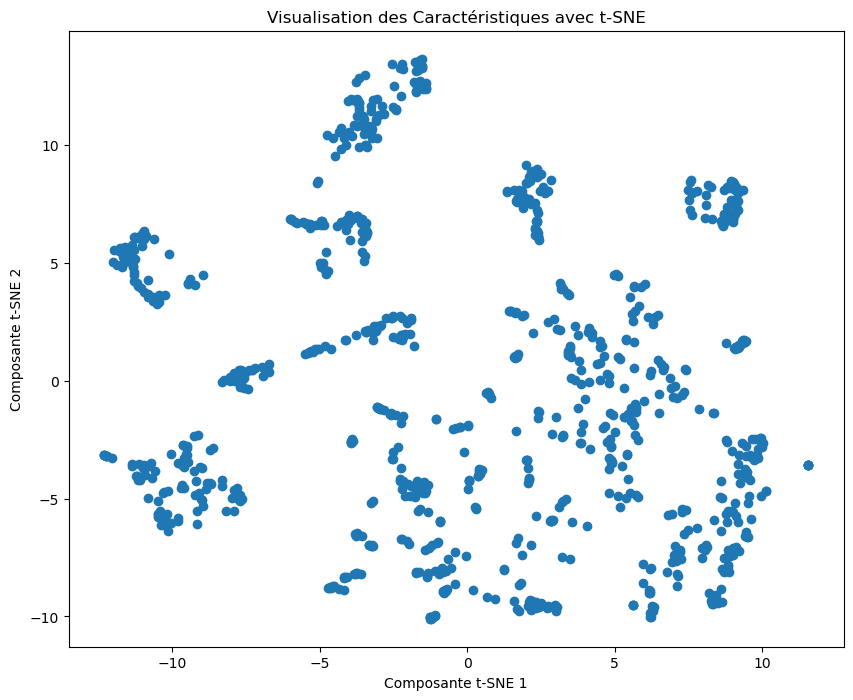

In [40]:
!pip install matplotlib scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



# Application de PCA pour réduire à 50 dimensions pour accélérer t-SNE
pca = PCA(n_components=50)
feats_reduced = pca.fit_transform(feats)

# Application de t-SNE pour réduire davantage à 2 dimensions pour la visualisation
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats_reduced)

# Visualisation des résultats de t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('Visualisation des Caractéristiques avec t-SNE')
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')
plt.show()
